<h1 style='font-family: Dalton White; font-weight: 600; font-size: 20px; text-align: left'>1.0. Import Required Libraries</h1>

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, kurtosis, gaussian_kde
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("\n----- Libraries Loaded Successfully -----\n")


----- Libraries Loaded Successfully -----



<h1 style='font-family: Dalton White; font-weight: 600; font-size: 20px; text-align: left'>2.0. Load and Inspect Dataset</h1>

In [2]:
FILEPATH = "./Datasets/Soil Survey Dataset 2025.csv"
df = pd.read_csv(FILEPATH)
display(df)

,Site,Ph,Organic Matter %,Nitrogen %,Phosphorus Mg/Kg,Potassium Cmol(+)/Kg,Cec Cmol(+)/Kg,Bulk Density G/Cm3,Electrical Conductivity Ds/M,Yield T/Ha
0,Lowland,6.35,2.45,0.27,20.07,0.47,12.04,1.17,0.18,5.64
1,Lowland,6.44,2.23,0.22,4.31,0.30,6.17,1.24,0.22,4.65
2,Lowland,6.33,2.51,0.15,20.35,0.25,13.03,1.21,0.19,4.40
3,Lowland,6.35,1.97,0.11,5.49,0.35,2.61,1.11,0.21,3.53
4,Lowland,5.86,2.38,0.24,10.12,0.46,11.52,1.20,0.09,4.76
...,...,...,...,...,...,...,...,...,...,...
315,Hillside,6.76,2.30,0.11,6.38,0.28,11.70,1.33,0.25,3.64
316,Hillside,5.54,2.53,0.20,8.42,0.22,10.23,1.31,0.18,4.10
317,Hillside,6.16,1.82,0.18,16.55,0.19,8.71,1.29,0.14,4.20
318,Hillside,6.14,1.48,0.16,1.68,0.28,7.01,1.31,0.32,3.14


In [3]:
def column_summaries(df: pd.DataFrame) -> pd.DataFrame:
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summaries(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Site,object,0,320,4,"{'Lowland': 80, 'Upland': 80, 'Riverine': 80, ..."
1,Ph,float64,0,320,320,"{5.933228114814507: 1, 6.020721227425298: 1, 5..."
2,Organic Matter %,float64,0,320,320,"{1.709687739036262: 1, 1.017733123757243: 1, 2..."
3,Nitrogen %,float64,0,320,320,"{0.1338622988365825: 1, 0.1556925471573393: 1,..."
4,Phosphorus Mg/Kg,float64,0,320,317,"{0.0: 4, 5.49154959069914: 1, 10.1209017459529..."
5,Potassium Cmol(+)/Kg,float64,0,320,320,"{0.4650672467557676: 1, 0.3842455089419334: 1,..."
6,Cec Cmol(+)/Kg,float64,0,320,320,"{6.3439350334633176: 1, 4.446053838740792: 1, ..."
7,Bulk Density G/Cm3,float64,0,320,320,"{1.1795347491202997: 1, 1.3487566896868544: 1,..."
8,Electrical Conductivity Ds/M,float64,0,320,320,"{0.1490615324175119: 1, 0.1151092847315608: 1,..."
9,Yield T/Ha,float64,0,320,320,"{3.771501912265703: 1, 2.919546106533629: 1, 3..."


<h1 style='font-family: Dalton White; font-weight: 600; font-size: 20px; text-align: left'>2. Statistics Description of Datasets</h1>

In [4]:
if __name__ == "__main__":
    results = df.describe(include='all').T
    display(results)

,count,unique,top,freq,mean,...,min,25%,50%,75%,max
Site,320,4,Lowland,80,NaN,...,NaN,NaN,NaN,NaN,NaN
Ph,320.00,NaN,NaN,NaN,6.22,...,4.86,5.96,6.20,6.50,7.18
Organic Matter %,320.00,NaN,NaN,NaN,2.36,...,0.54,1.91,2.30,2.83,4.46
Nitrogen %,320.00,NaN,NaN,NaN,0.18,...,0.03,0.15,0.18,0.22,0.40
Phosphorus Mg/Kg,320.00,NaN,NaN,NaN,12.70,...,0.00,8.23,12.35,17.03,27.49
Potassium Cmol(+)/Kg,320.00,NaN,NaN,NaN,0.36,...,0.02,0.27,0.36,0.45,0.76
Cec Cmol(+)/Kg,320.00,NaN,NaN,NaN,9.99,...,0.78,7.96,10.03,11.99,18.27
Bulk Density G/Cm3,320.00,NaN,NaN,NaN,1.25,...,0.97,1.19,1.24,1.31,1.51
Electrical Conductivity Ds/M,320.00,NaN,NaN,NaN,0.22,...,0.02,0.16,0.21,0.27,0.48
Yield T/Ha,320.00,NaN,NaN,NaN,4.43,...,2.56,3.88,4.41,5.00,6.79


In [7]:
def summary_statistics(df: pd.DataFrame, group: str=None) -> pd.DataFrame:
    if group:
        grouped = df.groupby(group)
    else:
        grouped = [(None, df)]

    results = []
    for group_name, group_df in grouped:
        for col in group_df.select_dtypes(include=[np.number]).columns:
            counts = group_df[col].count()
            mean = group_df[col].mean()
            median = group_df[col].median()
            mode = group_df[col].mode().iloc[0] if not group_df[col].mode().empty else np.nan
            std_dev = group_df[col].std()
            variance = group_df[col].var()
            value_range = group_df[col].max() - group_df[col].min()
            iqr = group_df[col].quantile(0.75) - group_df[col].quantile(0.25)
            skewness_val = skew(group_df[col], nan_policy='omit')
            kurtosis_val = kurtosis(group_df[col], nan_policy='omit')

            # Confidence Interval for the mean
            sem = stats.sem(group_df[col], nan_policy="omit")
            ci_low, ci_up = stats.t.interval(0.95, counts-1, loc=mean, scale=sem) if counts > 1 else (np.nan, np.nan)

            results.append({
                f'{group}': group_name,
                'Variable': col,
                'Mean': mean,
                'Median': median,
                'Mode': mode,
                'Std Deviation': std_dev,
                'Variance': variance,
                'Range': value_range,
                'IQR': iqr,
                'Skewness': skewness_val,
                'Kurtosis': kurtosis_val,
                '95% CI Lower': ci_low,
                '95% CI Upper': ci_up
            })

    results = pd.DataFrame(results)
    if group is None: results = results.drop(columns=[f'{group}'])
    return results

if __name__ == "__main__":
    results = summary_statistics(df)
    display(results)

,Variable,Mean,Median,Mode,Std Deviation,...,IQR,Skewness,Kurtosis,95% CI Lower,95% CI Upper
0,Ph,6.22,6.20,4.86,0.38,...,0.54,-0.18,0.08,6.18,6.26
1,Organic Matter %,2.36,2.30,0.54,0.68,...,0.92,0.23,-0.03,2.28,2.43
2,Nitrogen %,0.18,0.18,0.03,0.06,...,0.08,0.10,0.18,0.18,0.19
3,Phosphorus Mg/Kg,12.70,12.35,0.00,6.02,...,8.80,0.07,-0.67,12.04,13.36
4,Potassium Cmol(+)/Kg,0.36,0.36,0.02,0.13,...,0.18,0.18,0.01,0.35,0.38
5,Cec Cmol(+)/Kg,9.99,10.03,0.78,3.05,...,4.03,0.05,0.07,9.66,10.33
6,Bulk Density G/Cm3,1.25,1.24,0.97,0.09,...,0.12,0.01,-0.19,1.24,1.26
7,Electrical Conductivity Ds/M,0.22,0.21,0.02,0.08,...,0.11,0.30,0.25,0.21,0.22
8,Yield T/Ha,4.43,4.41,2.56,0.78,...,1.12,0.07,-0.29,4.34,4.51


<h1 style='font-family: Dalton White; font-weight: 600; font-size: 20px; text-align: left'>3.0. Calculate Pearsonr Correlatin Coefficients</h1>

In [16]:
from scipy.stats import pearsonr

def compute_pearson_r(df: pd.DataFrame, numerical_columns: list) -> pd.DataFrame:
    results = []

    for i, col1 in enumerate(numerical_columns):
        for col2 in numerical_columns[i+1:]:
            r_value, p_value = pearsonr(df[col1], df[col2])
            direction = ("Positive" if r_value > 0 else  "Negative" if r_value < 0 else "No correlation")
            strength = ("Strong" if abs(r_value) >= 0.7 else "Moderate" if abs(r_value) >= 0.3 else "Weak")

            results.append({
                'Variable 1': col1, 'Variable 2': col2,
                'Pearson\'s r': r_value, 'P-value': p_value,
                'Direction': direction, 'Strength': strength
            })
    
    return pd.DataFrame(results)

if __name__ == "__main__":
    variables = [
         'Organic Matter %',
         'Nitrogen %',
         'Phosphorus Mg/Kg',
         'Potassium Cmol(+)/Kg',
         'Cec Cmol(+)/Kg',
         'Bulk Density G/Cm3',
         'Electrical Conductivity Ds/M',
         'Yield T/Ha'
        ]
    results = compute_pearson_r(df, numerical_columns=variables)
    display(results)



,Variable 1,Variable 2,Pearson's r,P-value,Direction,Strength
0,Organic Matter %,Nitrogen %,0.20,0.00,Positive,Weak
1,Organic Matter %,Phosphorus Mg/Kg,0.34,0.00,Positive,Moderate
2,Organic Matter %,Potassium Cmol(+)/Kg,0.19,0.00,Positive,Weak
3,Organic Matter %,Cec Cmol(+)/Kg,0.07,0.24,Positive,Weak
4,Organic Matter %,Bulk Density G/Cm3,-0.25,0.00,Negative,Weak
5,Organic Matter %,Electrical Conductivity Ds/M,0.22,0.00,Positive,Weak
6,Organic Matter %,Yield T/Ha,0.60,0.00,Positive,Moderate
7,Nitrogen %,Phosphorus Mg/Kg,0.23,0.00,Positive,Weak
8,Nitrogen %,Potassium Cmol(+)/Kg,0.17,0.00,Positive,Weak
9,Nitrogen %,Cec Cmol(+)/Kg,-0.00,0.99,Negative,Weak


<h1 style='font-family: Dalton White; font-weight: 600; font-size: 20px; text-align: left'>4.0. Visualizing Customized Pairplot</h1>

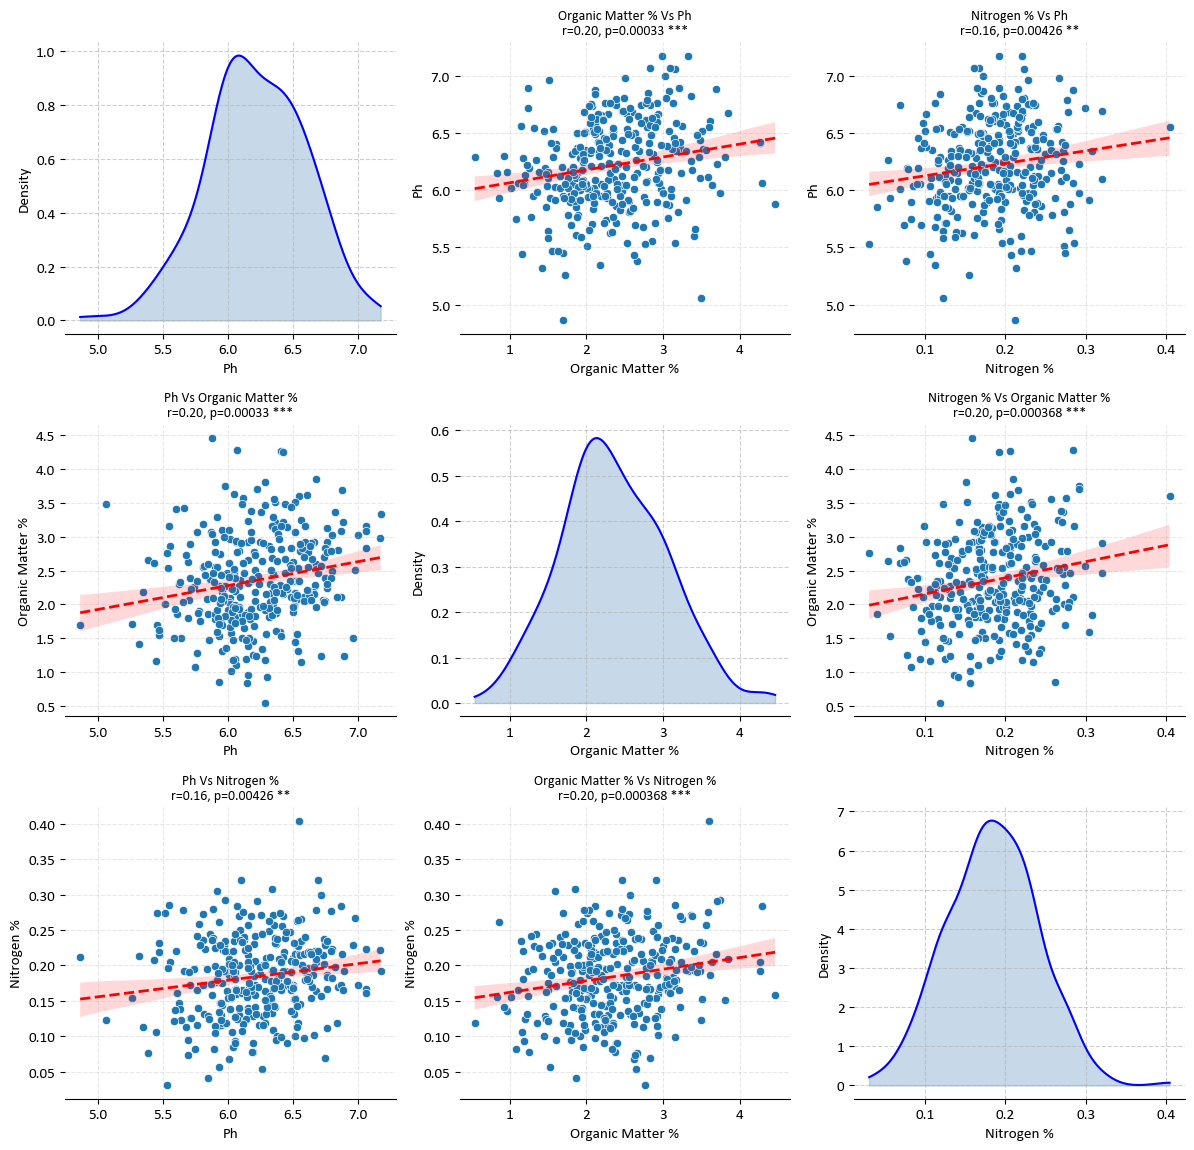

In [21]:
def significance_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'ns'


def visualize_pairplot(df: pd.DataFrame, variables: list, group: str = None, cmap: str = 'viridis'):
    num_variables = len(variables)
    rows = num_variables 
    cols = num_variables
    
    fig, axes = plt.subplots(rows, cols, figsize=(4* cols, 4*rows))
    plt.rcParams.update({'font.family': 'Calibri', 'font.size': 11 })
    
    for i in range(num_variables):
        for j in range(num_variables):
            ax = axes[i, j]
            if i == j:
                if group != None:
                    categories = df[group].unique()
                    cmap_obj = plt.get_cmap(cmap)
                    colors = [cmap_obj(i / len(categories)) for i in range(len(categories))]
                    x_range = np.linspace(df[variables[j]].min(), df[variables[j]].max(), 1000)
                    
                    for sp, color in zip(categories, colors):
                        data = df[df[group] == sp][variables[j]]
                        kde = gaussian_kde(data)
                        ax.plot(x_range, kde(x_range), label=sp, color=color)
                        ax.fill_between(x_range, kde(x_range), alpha=0.3, color=color)  
                        ax.legend(frameon=False)
                        
                else:
                    
                    data = df[variables[j]]
                    kde = gaussian_kde(data)
                    x_range = np.linspace(df[variables[j]].min(), df[variables[j]].max(), 1000)
                    ax.plot(x_range, kde(x_range), color='blue')
                    ax.fill_between(x_range, kde(x_range), alpha=0.3, color='steelblue')
                   
                ax.spines[['right', 'top', 'left']].set_visible(False)
                ax.set_xlabel(variables[j], fontsize=11)
                ax.set_ylabel('Density', fontsize=11)
                ax.grid(linestyle='--', alpha=0.6)
            else:
                r, p = pearsonr(df[variables[j]], df[variables[i]])
                stars = significance_stars(p)
                sns.scatterplot(data=df, x=df[variables[j]], y=df[variables[i]], ax=ax, hue=group, style=group, alpha=1, palette=cmap)
                sns.regplot(data=df, x=df[variables[j]], y=df[variables[i]], ax=ax,  scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'lw': 2})
                title = f"{variables[j]} Vs {variables[i]}"
                ax.set_title(f"{title}\nr={r:.2f}, p={p:.3g} {stars}", fontsize=10)
                sns.despine(left=True, bottom=False)
                ax.set_xlabel(variables[j], fontsize=11)
                ax.set_ylabel(variables[i], fontsize=11)
                ax.grid(linestyle='--', alpha=0.3)
                ax.legend(frameon=False)
        
    for i in range(num_variables):
        for j in range(num_variables):
            if i == j:
                axes[i, j].axis('on') 
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

if __name__ == "__main__":
    variables = df.select_dtypes(include=['number']).columns[:3]
    visualize_pairplot(df, variables)

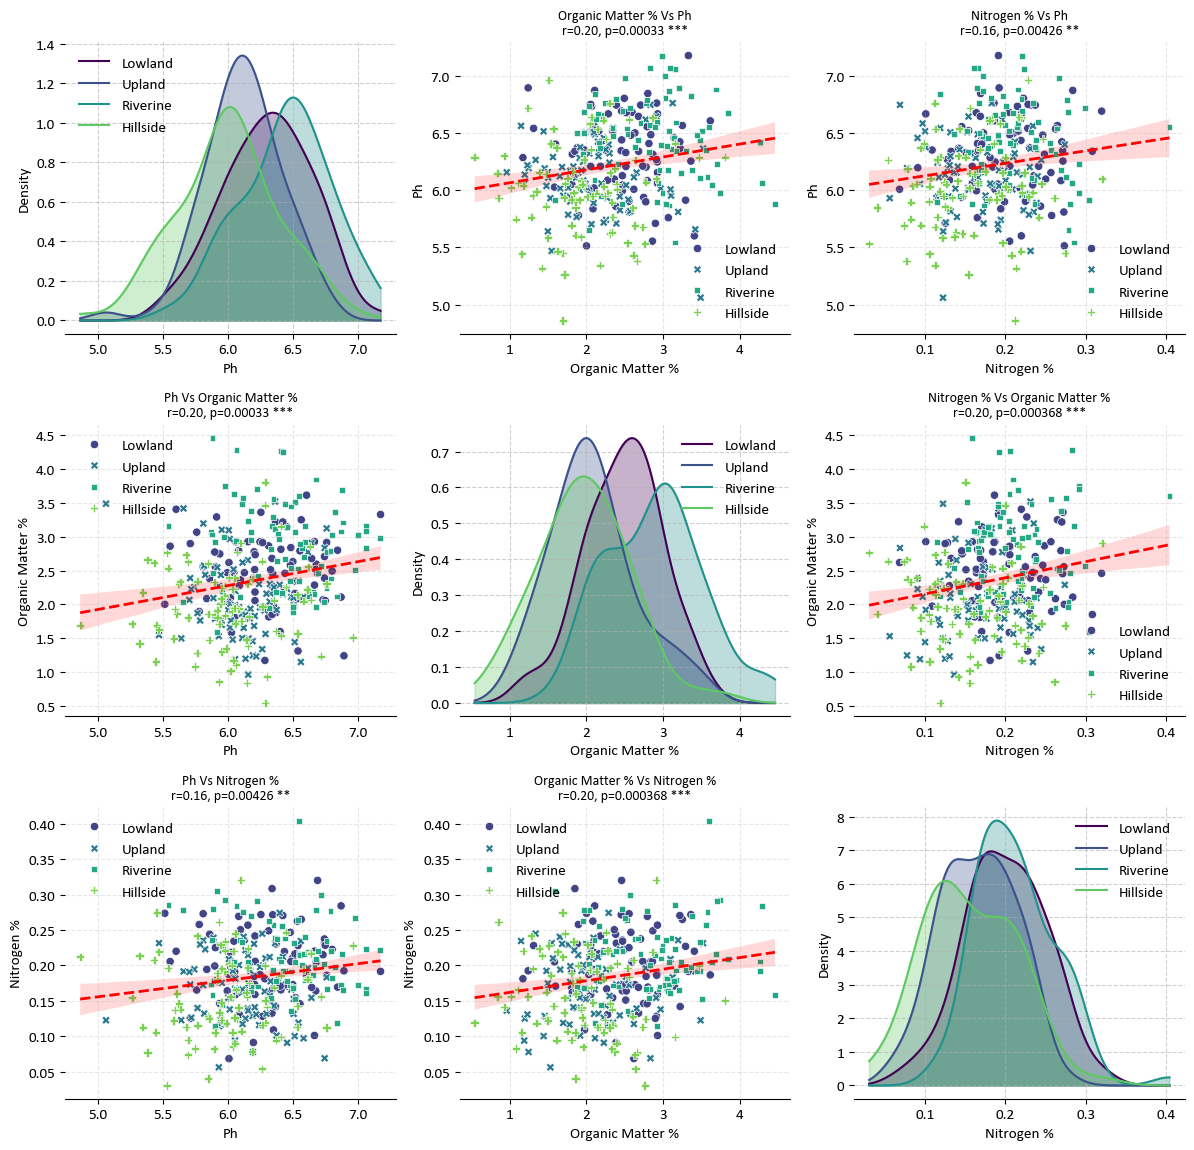

In [23]:
if __name__ == "__main__":
    variables = df.select_dtypes(include=['number']).columns[:3]
    visualize_pairplot(df, variables, group='Site')

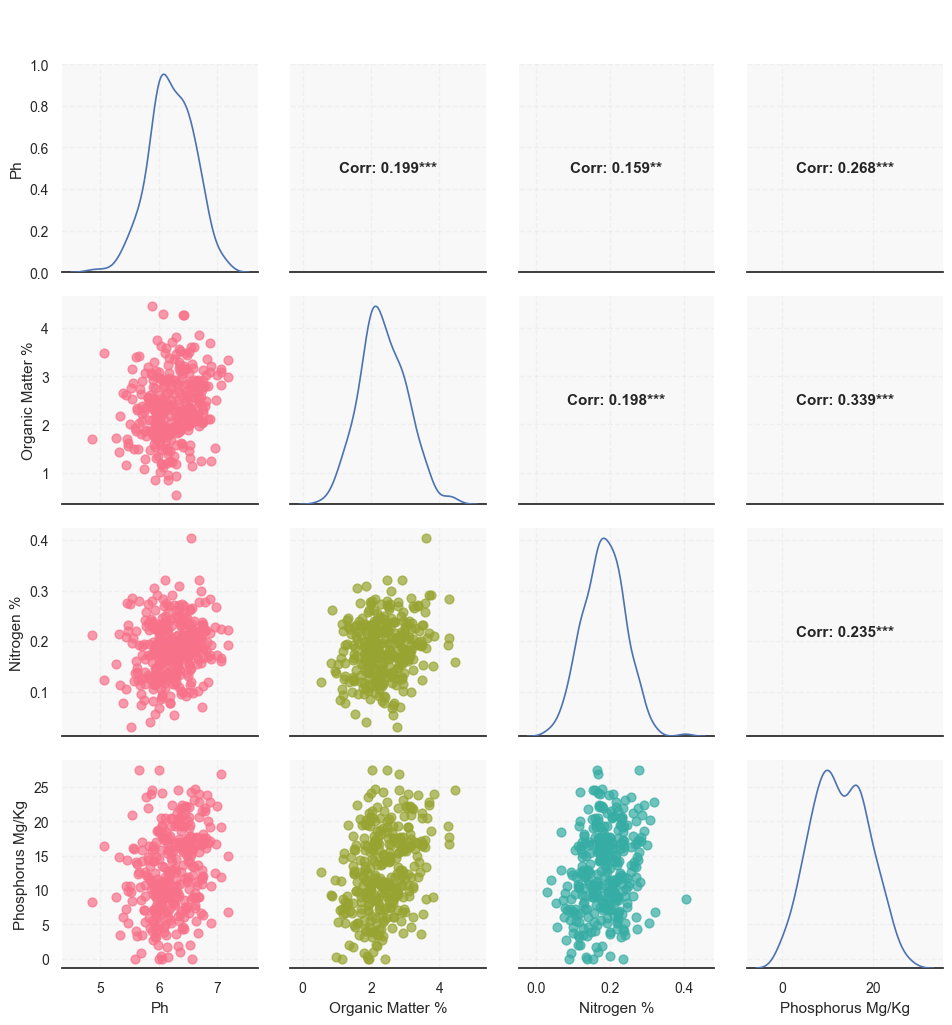

In [25]:
import scipy.stats as stats

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    stars = 'ns'
    if p <= 0.001: stars = '***'
    elif p <= 0.01: stars = '**'
    elif p <= 0.05: stars = '*'
    ax = plt.gca()
    
    ax.annotate(
            f"Corr: {r:.3f}{stars}", 
            xy=(0.5, 0.5), 
            xycoords=ax.transAxes,
            ha='center', 
            va='center', 
            fontsize=11, 
            fontweight='bold'
    )

def scatter_with_labels(x, y, **kwargs):
    ax = plt.gca()
    sns.scatterplot(
        x=x, 
        y=y, 
        s=kwargs.pop("s", 35), 
        color=kwargs.pop("marker_color", "black"), 
        alpha=0.7, 
        ax=ax)


def plot_pairplot(df, title=" ", label_fontsize=10, marker_size=35):
    palette = sns.color_palette("husl", len(df.columns))
    g = sns.PairGrid(df, diag_sharey=False, layout_pad=0.5)
    for i, row_var in enumerate(df.columns):
        for j, col_var in enumerate(df.columns):
            if i > j: g.axes[i, j].scatter(
                df[col_var], 
                df[row_var], 
                s=marker_size, 
                color=palette[j], 
                alpha=0.7
            )

    g.map_upper(corrfunc)
    g.map_diag(sns.kdeplot, fill=False, lw=1.2)

    for i, row_vars in enumerate(df.columns):
        for j, col_vars in enumerate(df.columns):
            ax = g.axes[i, j]
            #if i != j: ax.set_title(f"{row_vars} vs {col_vars}", fontsize=label_fontsize, pad=5)
            if i == len(df.columns) - 1: ax.set_xlabel(col_vars, fontsize=label_fontsize)
            if j == 0: ax.set_ylabel(row_vars, fontsize=label_fontsize)

    g.fig.suptitle(title, fontsize=16, fontweight='bold', fontfamily = 'Agency FB', y=1.03)
    for ax in g.axes.flatten():
        ax.set_facecolor("#f8f8f8")
        ax.tick_params(axis='both', labelsize=label_fontsize-1)
        ax.grid(linestyle='--', alpha=0.2)
        sns.despine(ax=ax, left=True)

    plt.show()

if __name__ == "__main__":
    data = df[df.select_dtypes(include=['number']).columns[:4]]
    plot_pairplot(data, label_fontsize=11, marker_size=40)